Ryan Leeson, Keith Jennings

In [2]:
#! scancel -u ryan.leeson -n sparkcluster 

In [4]:
import os, atexit, sys, findspark, sparkhpc, pyspark
from pyspark.context import SparkContext
from pyspark.sql import SQLContext

findspark.init()

# specify your partition (unless you're OK with default)
os.environ['SBATCH_PARTITION']='cpu24'

sj = sparkhpc.sparkjob.sparkjob(
    ncores = 10,                       # total number or cores
    cores_per_executor = 5,            # parallelism of two executor
    memory_per_core = 10240,           # memory per core in MB 
    walltime = "4:0"                   # hh:mm format
)

sj.wait_to_start()
sc = sj.start_spark()
scq = SQLContext(sc)

def exitHandler(sj,sc):
    try:
        print('Trapped Exit cleaning up Spark Context')
        sc.stop()
    except:
        pass
    try:
        print('Trapped Exit cleaning up Spark Job')
        sj.stop()
    except:
        pass
atexit.register(exitHandler,sj,sc);
sc

INFO:sparkhpc.sparkjob:Submitted batch job 8932

INFO:sparkhpc.sparkjob:Submitted cluster 1


<SparkContext master=spark://b07:7077 appName=pyspark-shell>

In [5]:
from textblob import TextBlob

from pyspark.ml.feature import StopWordsRemover

from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import col, udf, concat
from pyspark.sql import functions as f

from pyspark.ml import Pipeline

from pyspark.sql.functions import input_file_name
from pyspark.sql.types import *

from pyspark.sql.functions import split, lower

from pyspark.ml.feature import NGram, FeatureHasher, CountVectorizer, RegexTokenizer

from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import VectorAssembler


from itertools import chain
import numpy as np
import pandas as pd


from pyspark import keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param, Params, TypeConverters
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable  
from pyspark.sql.functions import udf, create_map, lit
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.window import Window

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Text analysisf of Amazon product reviews

### DS 608 Project
#### By Keith Jennings, Ryan Leeson

## Introduction

#### With presence of social media and online reviews, people's thoughts and opinions travel throughout our digital landscape. However, that still leaves the necessity to understand what it is people are trying to convey. The simplest thing to do is to read the posts that people put only, but with the number of posts that can be sent on a single subject, it is not feasable to expect anyone to read all those posts and understand what people's feelings on a subject might be. That is where data science comes in.Using text analysis and classification algorithms, the posts left by the users of these various online services can be quickly analysed and evaluated to determine how a person fell regarding a subject.

#### In this report, we train of multinomial logistic regression model using an Amazon product review dataset. The advantage of using the Amazon review dataset is that it does not only include text-based data, it also includes an evaluation system in the form of a five star rating, where one and two stars show dislike or displeasure, four and five show people like and  enjoy something, and three stars is a neutral position. With review texts and the associated star rating a model can be trained to evaluate a post and classifying it with a star rating to indicate whether the post indicates like or dislike regard the subject of the post.

## Dataset

#### The datset was was compiled by Jianmo Ni, a Ph.D. student from the University of California San Diego. The dataset is hosted on a github repository controlled by Mr. Ni. 

#### The dataset is stored as 29 seperate Json files. Each file consists of the reviews for each product category. The files vary in size from ~100 MB to the largest file, which are book reviews which is ~7 GB. Overall, all the files combined contain approximately 14 GB of data.

#### The data include product reviews taken from 1996 up to the year 2018. The features of the dataset include response variable, 'overall,' which is overall rating of the product on a five point scale. Other features include the 'asin' which is a product identifier, 'image' which is a link to an image of the product, if available. For the reviews, there is the 'reviewText' which is the full review text written by the review author. Other features included are the time the review was made, as a date and as a UNIX timestamp, 'revieTime' and 'unixReviewTime.' There are also the reviewer's name, 'reviewerName,' and ID; 'reviewerID,' the 'summary,' a short text briefly stating the authors thoughts, 'verified' varifying the author of the product made the purchase, and 'vote' summarising whether the review received up or down votes.

#### The dataset was pre-cleaned by Mr. Ni. Mr. Ni has versions of the files available through his github repo. The master file, containing all reviews collected by Mr. Ni, includes over 233 million reviews and is approximately 34 GB in size. The dataset used is referred to as a 5-core dataset. The title is defined to indicate that only products with a minimum of five reivews or reviews who have left a minimum of five reviews were included.


## Methods

### File collection
#### The code used to download the files from Mr. Ni's gihub page is provided in a different file titled 'batch_program_for_download.ipynb.'


#### The download was done through a programmed written as a SLURM job run on the University of Calgary's TALC cluster system. Using one node and 16 cores, the job took 50.3 minutes (3020.565 s) to download all the files.

### Converting files to parquet

In [ ]:
%%time
df_reviews = scq.read.json ('Files/*.json.gz')
#   There is a 'Files' folder where all the files were stored.

(df_reviews
 ##########
 #   Adding a category feature.
 .withColumn ('filename', input_file_name ())
 .withColumn ('file_cn', split (col ('filename'), 'Files/').getItem (1))
 #   This line is dependent on how files were organised
 .withColumn ('category', lower (split (col ('file_cn'), '_5.json').getItem (0)))
 ##########
 .select (['asin', 'overall', 'reviewText', 'reviewTime', 'reviewerID', 'summary', 'unixReviewTime', 'verified', 'category'])
 .write.parquet ('Files/amazon_reviews.parquet', mode = 'overwrite')
)

#### The original downloaded files were stored in json format with Gzip compression. Using pyspark the data was read into a spark dataframe and exported as new files in parquet format using snappy compression.

#### Using the titles of the files, a new category column was added to the data. During the creation of the parquet files, the category was used to partion the parquets, resulting in files like those originally downloaded.

#### A custom schema was not implemented for reading the json files. Two features, 'photo' and 'style,' contained nested structures. These nested structures caused issues when reading the json files. Also, examining multiple files showed the nested compents were different sizes between each file. Because of the issue with the nested schema and because the shema could be inferred, a custom schema was not produced. 


In [6]:
df = scq.read.parquet ('Files/amazon_reviews.parquet').select ('overall', 'reviewText')

In [7]:
#   View the imported dataframe

df.show (5)

+-------+--------------------+
|overall|          reviewText|
+-------+--------------------+
|    5.0|The King, the Mic...|
|    5.0|  The kids loved it!|
|    5.0|My students (3 & ...|
|    5.0|             LOVE IT|
|    5.0|              Great!|
+-------+--------------------+
only showing top 5 rows



In [8]:
print (f'There are {df.count ()} entries in the dataset.')

There are 75257650 entries in the dataset.


In [13]:
#   Counts for each class and their percentage of the dataset.

(df.groupBy ('overall')
 .count ()
 .withColumn ('percent', f.col ('count') / f.sum ('count').over (Window.partitionBy ()))
 .orderBy ('overall', ascending = False)
 .show ()
)

+-------+--------+--------------------+
|overall|   count|             percent|
+-------+--------+--------------------+
|    5.0|48469822|  0.6440517608508902|
|    4.0|14146238|  0.1879707644339147|
|    3.0| 6307898| 0.08381736607507675|
|    2.0| 3068487|  0.0407730908419277|
|    1.0| 3265202|0.043386977935133506|
|    0.0|       3|3.986305711113754E-8|
+-------+--------+--------------------+



### Data cleaning

#### The data was pre-cleaned by Mr. Ni, however, more wrangling was performed to further reduce the dataset. First, all duplicate entries were removed. 

In [11]:
#   Remove entries with duplicates, oveall < 1, and NA values in 'reviewText'

#   There is an unexplained sixth class, 0.0. Because the meaning is unknown it can be removed.
#   Because we are only examining the text of the reviews and not any other related data about the 
#   products or the reviewers, all the duplicates can be removed.
#   The text is what is being examined, so nulls in the 'reivewText' column are removed from the dataset.

df_cleaned = df.where (df.overall > 0).dropDuplicates ().na.drop (subset = ['reviewText'])

print (f'After cleaning there are {df_cleaned.count ()} entries remaining.')

After cleaning there are 62454271 entries remaining.


#### After cleaning, the dataset consisted of 62454271 product reviews.

In [12]:
#   New count and percent of classes after cleaning.

df_counts = (df_cleaned.groupBy ('overall')
 .count ()
 .withColumn ('percent', f.col ('count') / f.sum ('count').over (Window.partitionBy ()))
 .orderBy ('overall', ascending = False)
)

df_counts.show ()

+-------+--------+--------------------+
|overall|   count|             percent|
+-------+--------+--------------------+
|    5.0|38853017|  0.6221034426932948|
|    4.0|12312315| 0.19714128117835208|
|    3.0| 5616059| 0.08992273722961237|
|    2.0| 2776926|0.044463348231220244|
|    1.0| 2895954|0.046369190667520564|
+-------+--------+--------------------+



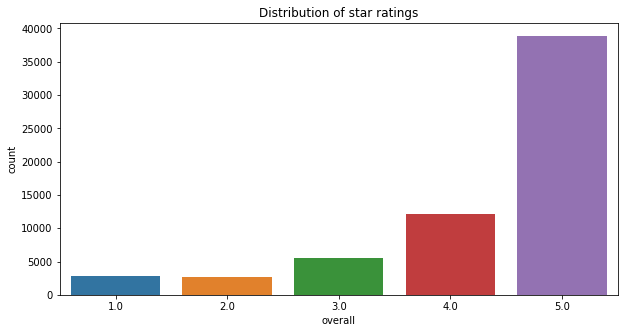

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

pdf = df_cleaned.sample (False, 0.001).toPandas ()

plt.figure (figsize = (10,5))
sns.countplot (x = pdf["overall"]).set_title ("Distribution of star ratings")
#plt.savefig ('amazon_stars.png')
plt.show ()